# Model

In [60]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

### Dataset info
1. sales
: date, date_block_num, shop_id, item_id, item_price, item_cnt_day

2. item_cat
: item_category_name, item_category_id

3. item
: item_name, item_id, item_category_id

4. shops
: shop_name, shop_id


### Variables
 + ID - an Id that represents a (Shop, Item) tuple within the test set
 + shop_id - unique identifier of a shop
 + item_id - unique identifier of a product
 + item_category_id - unique identifier of item category
 + item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
 + item_price - current price of an item
 + date - date in format dd/mm/yyyy
 + date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 + item_name - name of item
 + shop_name - name of shop
 + item_category_name - name of item category

In [2]:
train = pd.read_csv('sales_train.csv')
item_cat = pd.read_csv('item_categories.csv')
item = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(item_cat.shape)
print(item.shape)
print(shops.shape)
print(test.shape)

(2935849, 6)
(84, 2)
(22170, 3)
(60, 2)
(214200, 3)


In [3]:
train['date'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

item_price와 item_cnt_day 변수에서 음수값 존재

In [4]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


item_price 가 음수인 데이터는 1개이므로 제거

In [5]:
print('%d개' % train[train['item_price']<0].shape[0])
train = train[train['item_price'] >=0]

1개


item_cnt_day 가 음수인 데이터는 7356개 --> 보류

In [6]:
print('%d개' % train[train['item_cnt_day']<0].shape[0])

7356개


### Outlier

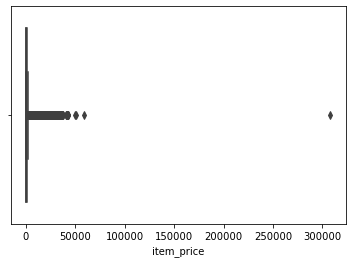

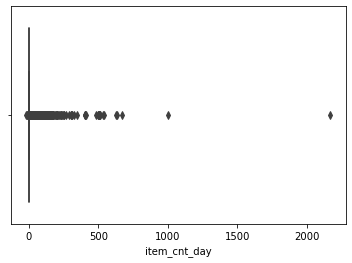

In [7]:
plt.figure(figsize = (6, 4))
sns.boxplot(train['item_price'])
plt.show()

plt.figure(figsize = (6, 4))
sns.boxplot(train['item_cnt_day'])
plt.show()

In [8]:
# remove outliers
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 1500]

### Shops data
 + shop_name은 city로 시작
 + shops data를 city code와 shop_id로 표현

In [9]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops = shops[['shop_id', 'city_code']]

### Category data
 + type - subtype 구성

In [10]:
item_cat['type'] = item_cat['item_category_name'].str.split('-').map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
item_cat['subtype'] = item_cat['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id', 'type_code', 'subtype_code']]

In [11]:
item.drop('item_name', axis = 1, inplace = True)

## Test set vs Train set

In [12]:
test_n = len(list(set(test['item_id'])-set(test['item_id']).intersection(set(train['item_id']))))
print('Test set contains %d new items compared to train set' % test_n)

Test set contains 363 new items compared to train set


Since test set contains 363 new items, their sales in train set are zero.

 + `product`: 지정한 list들의 모든 가능한 조합을 찾는 method

In [13]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

`numpy.clip(array, min, max)`

array 내의 element들에 대해서 min 값 보다 작은 값들을 min값으로 바꿔주고 max 값 보다 큰 값들을 max값으로 바꿔주는 함수.

 + clip(0, 20)을 통해 train set과 test set의 item_cnt_month 범위를 맞춰줌

In [14]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'})
group.columns = ['item_cnt_month']
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = cols, how = 'left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [16]:
test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [17]:
matrix = pd.concat([matrix, test], ignore_index = True, sort = False, keys = cols)
matrix.fillna(0, inplace = True)

In [18]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, item, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_cat, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

### Target lagged features

In [19]:
def lag_feats(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + '_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
        
    return df

In [20]:
matrix = lag_feats(matrix, [1,2,3,6,12], 'item_cnt_month')

### Mean encoded features
각종 변수 조합에 대해 Target 변수에 대한 mean encoded feature 생성

In [21]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [22]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [23]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [24]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [25]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [26]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [27]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [28]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [29]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [30]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [31]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feats(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### Trend features
특정 변수의 trend를 반영하기 위한 trend feature를 생성한다. 1차 차분한 값을 tred feature로 정의하며, lag는 1, 2, 3, 4, 5, 6으로 다양하게 지정한다.

In [32]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ['item_id'], how = 'left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ['date_block_num', 'item_id'], how = 'left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feats(matrix, lags, 'date_item_avg_item_price')

# 차분 변수
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)]
                                        -matrix['item_avg_item_price'])/matrix['item_avg_item_price']
    


def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [33]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [34]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feats(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Monthly/days features

In [35]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### Extra processing

In [36]:
matrix = matrix[matrix.date_block_num > 11]

In [37]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_'in col) & (df[col].isna().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace = True)
    return df

matrix = fill_na(matrix)

## LightGBM Model

In [39]:
data = matrix[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days'
]]

In [53]:
data = data.reset_index(drop = True)

 + Time series cross validation은 위와 같이 전처리된 데이터에는 적합하지 않음

KeyboardInterrupt: 

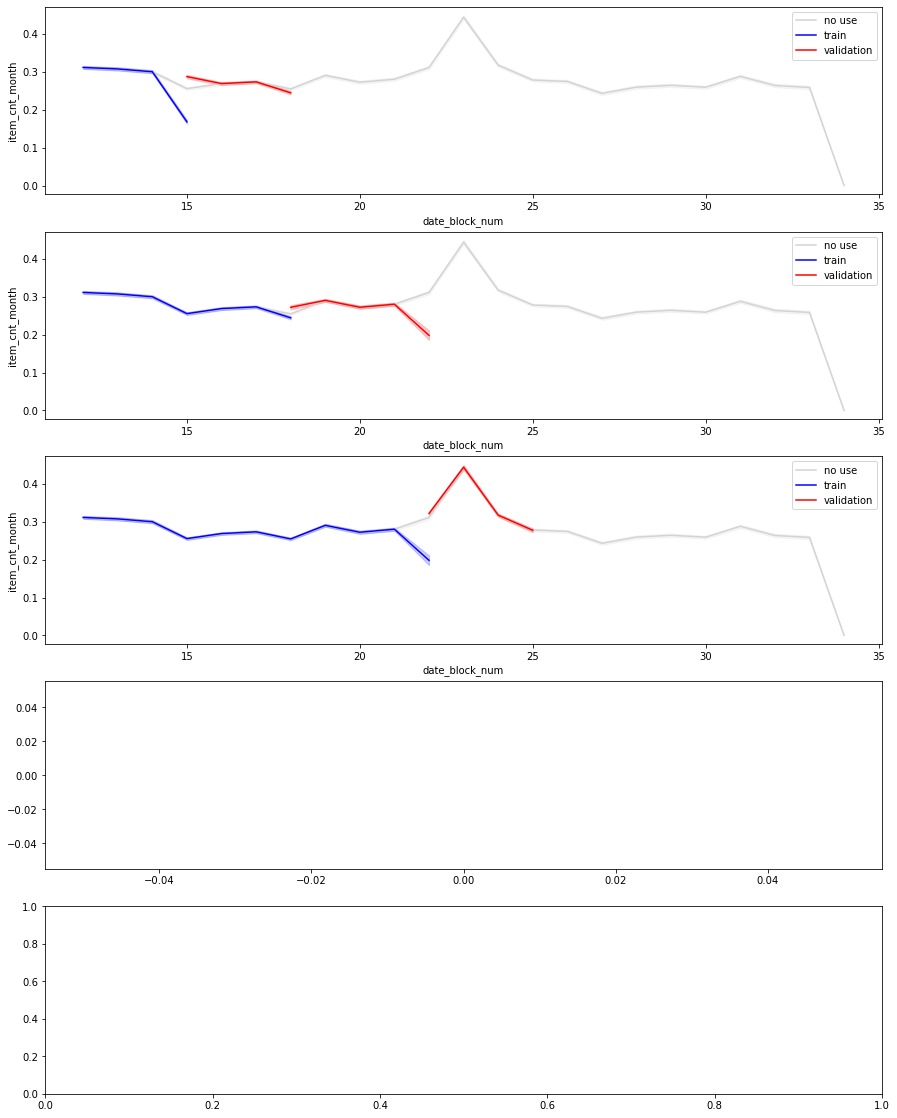

In [49]:
fig, axes = plt.subplots(5, 1, figsize = (15, 20))
folds = TimeSeriesSplit(n_splits = 5)

for i, (train_idx, val_idx) in enumerate(folds.split(data)):
    sns.lineplot(data = data, x = 'date_block_num', y = 'item_cnt_month', ax = axes[i], label = 'no use', color = 'lightgrey')
    sns.lineplot(data = data.iloc[train_idx, :], x = 'date_block_num', y = 'item_cnt_month', ax = axes[i], label = 'train', color = 'b')
    sns.lineplot(data = data.iloc[val_idx, :], x = 'date_block_num', y = 'item_cnt_month', ax = axes[i], label = 'validation', color = 'r')
    
plt.legend()
plt.show()

### Train test split
시계열데이터의 경우 KFold와 같이 랜덤으로 데이터를 train, validation set에 나누기보다는 시점을 지정해서 나누어준다.
시점은 앞에서부터 차례로 나누며, 해당 데이터에서는 약 5:1의 비율로 split 해주었다.

In [56]:
train = data.query('date_block_num < 29').copy()
valid = data.query('date_block_num >= 29 and date_block_num < 34').copy()
test = data.query('date_block_num == 34').copy()

print('Train set: ', train.shape)
print('Valid set: ', valid.shape)
print('Test set: ', test.shape)

Train set:  (5300554, 35)
Valid set:  (1124540, 35)
Test set:  (214200, 35)


In [59]:
X_train = train.drop(['date_block_num', 'item_cnt_month'], axis = 1)
y_train = train['item_cnt_month'].astype(int)
X_valid = valid.drop(['date_block_num', 'item_cnt_month'], axis = 1)
y_valid = valid['item_cnt_month'].astype(int)

In [61]:
model = LGBMRegressor(n_estimators = 1000,
                      max_depth = 10,
                      num_leaves = 20,
                      colsample_bytree = 0.8,
                      subsample = 0.7,
                      seed = 0)

model.fit(X_train, y_train, eval_metric = 'rmse', eval_set = [(X_train, y_train), (X_valid, y_valid)],
         verbose = True, early_stopping_rounds = 100)

[1]	training's rmse: 1.16191	training's l2: 1.35004	valid_1's rmse: 1.04663	valid_1's l2: 1.09544
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.12363	training's l2: 1.26255	valid_1's rmse: 1.01451	valid_1's l2: 1.02922
[3]	training's rmse: 1.09352	training's l2: 1.19578	valid_1's rmse: 0.990278	valid_1's l2: 0.980651
[4]	training's rmse: 1.06515	training's l2: 1.13454	valid_1's rmse: 0.967027	valid_1's l2: 0.935142
[5]	training's rmse: 1.04376	training's l2: 1.08943	valid_1's rmse: 0.950873	valid_1's l2: 0.90416
[6]	training's rmse: 1.02192	training's l2: 1.04433	valid_1's rmse: 0.932816	valid_1's l2: 0.870146
[7]	training's rmse: 1.00318	training's l2: 1.00638	valid_1's rmse: 0.917822	valid_1's l2: 0.842397
[8]	training's rmse: 0.988218	training's l2: 0.976575	valid_1's rmse: 0.905837	valid_1's l2: 0.820541
[9]	training's rmse: 0.976072	training's l2: 0.952716	valid_1's rmse: 0.895671	valid_1's l2: 0.802226
[10]	training's rmse: 0.96541	training'

[81]	training's rmse: 0.852115	training's l2: 0.7261	valid_1's rmse: 0.820471	valid_1's l2: 0.673173
[82]	training's rmse: 0.851594	training's l2: 0.725212	valid_1's rmse: 0.820351	valid_1's l2: 0.672976
[83]	training's rmse: 0.851199	training's l2: 0.72454	valid_1's rmse: 0.820277	valid_1's l2: 0.672854
[84]	training's rmse: 0.850829	training's l2: 0.723911	valid_1's rmse: 0.82024	valid_1's l2: 0.672794
[85]	training's rmse: 0.850481	training's l2: 0.723317	valid_1's rmse: 0.820141	valid_1's l2: 0.672631
[86]	training's rmse: 0.850135	training's l2: 0.72273	valid_1's rmse: 0.820046	valid_1's l2: 0.672476
[87]	training's rmse: 0.849861	training's l2: 0.722263	valid_1's rmse: 0.820041	valid_1's l2: 0.672468
[88]	training's rmse: 0.849375	training's l2: 0.721438	valid_1's rmse: 0.819925	valid_1's l2: 0.672277
[89]	training's rmse: 0.849081	training's l2: 0.720939	valid_1's rmse: 0.819848	valid_1's l2: 0.67215
[90]	training's rmse: 0.848825	training's l2: 0.720504	valid_1's rmse: 0.819824

[161]	training's rmse: 0.82745	training's l2: 0.684674	valid_1's rmse: 0.81948	valid_1's l2: 0.671548
[162]	training's rmse: 0.827131	training's l2: 0.684145	valid_1's rmse: 0.819483	valid_1's l2: 0.671553
[163]	training's rmse: 0.826997	training's l2: 0.683924	valid_1's rmse: 0.819405	valid_1's l2: 0.671425
[164]	training's rmse: 0.82683	training's l2: 0.683647	valid_1's rmse: 0.819328	valid_1's l2: 0.671298
[165]	training's rmse: 0.826683	training's l2: 0.683405	valid_1's rmse: 0.819318	valid_1's l2: 0.671282
[166]	training's rmse: 0.825771	training's l2: 0.681898	valid_1's rmse: 0.819939	valid_1's l2: 0.672301
[167]	training's rmse: 0.825603	training's l2: 0.681621	valid_1's rmse: 0.819875	valid_1's l2: 0.672195
[168]	training's rmse: 0.825457	training's l2: 0.681379	valid_1's rmse: 0.819878	valid_1's l2: 0.672201
[169]	training's rmse: 0.82535	training's l2: 0.681202	valid_1's rmse: 0.819858	valid_1's l2: 0.672166
[170]	training's rmse: 0.825253	training's l2: 0.681042	valid_1's rm

LGBMRegressor(colsample_bytree=0.8, max_depth=10, n_estimators=1000,
              num_leaves=20, seed=0, subsample=0.7)

In [68]:
feat_imp = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
feat_imp.sort_values(by = 'importance', ascending = False)

,feature,importance
12,date_item_avg_item_cnt_lag_1,262
3,item_category_id,182
30,delta_price_lag,170
31,month,168
1,item_id,167
6,item_cnt_month_lag_1,143
28,date_type_avg_item_cnt_lag_1,116
11,date_avg_item_cnt_lag_1,111
25,date_shop_subtype_avg_item_cnt_lag_1,104
29,date_subtype_avg_item_cnt_lag_1,90
